> Data set link on kaggle
 https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

In [ ]:
!pip install lightgbm imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Data Overview
print("Shape:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nSummary Stats:\n", data.describe())

Shape: (768, 9)

Data Types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Summary Stats:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max    

In [ ]:
columns_to_fill = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_to_fill] = data[columns_to_fill].replace(0, np.nan)
print(data.isna().sum())

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data = data_imputed.copy()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


> handle missing value

In [ ]:
print(data.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


> scatterplot this one show BMI and insulin. It shows insulin counts above 75 resulted in more cases of diabetes.

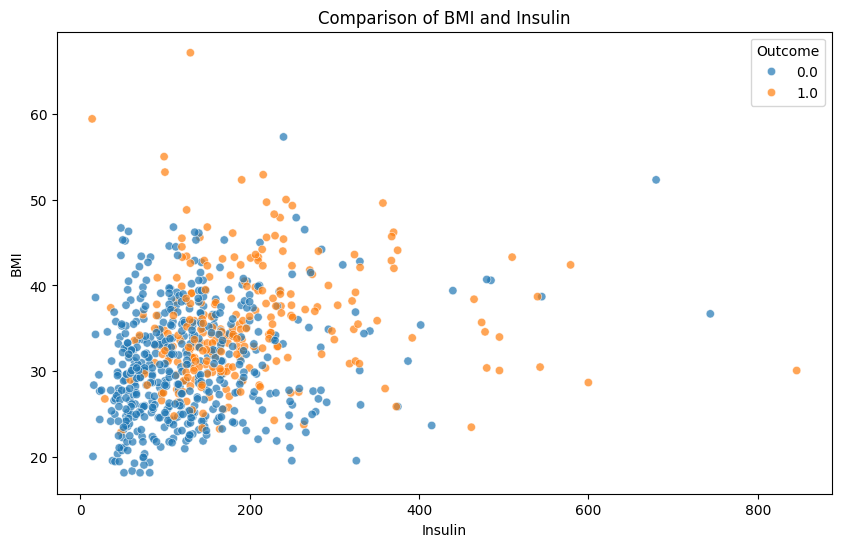

In [ ]:
df=data
plt.figure(figsize=(10,6))
# sns.dark_palette("muted", as_cmap=True)
sns.scatterplot(x='Insulin', y='BMI', data=df, hue='Outcome', alpha= 0.7)
plt.title('Comparison of BMI and Insulin')
plt.show()

> **A** pie showing the overall count of negative cases (500) and positive cases (268).

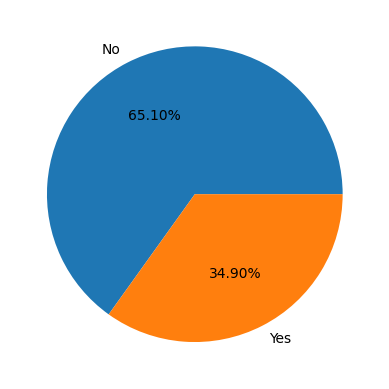

In [ ]:
plt.pie(data["Outcome"].value_counts(), labels=['No','Yes'], autopct="%1.2f%%")
plt.show()

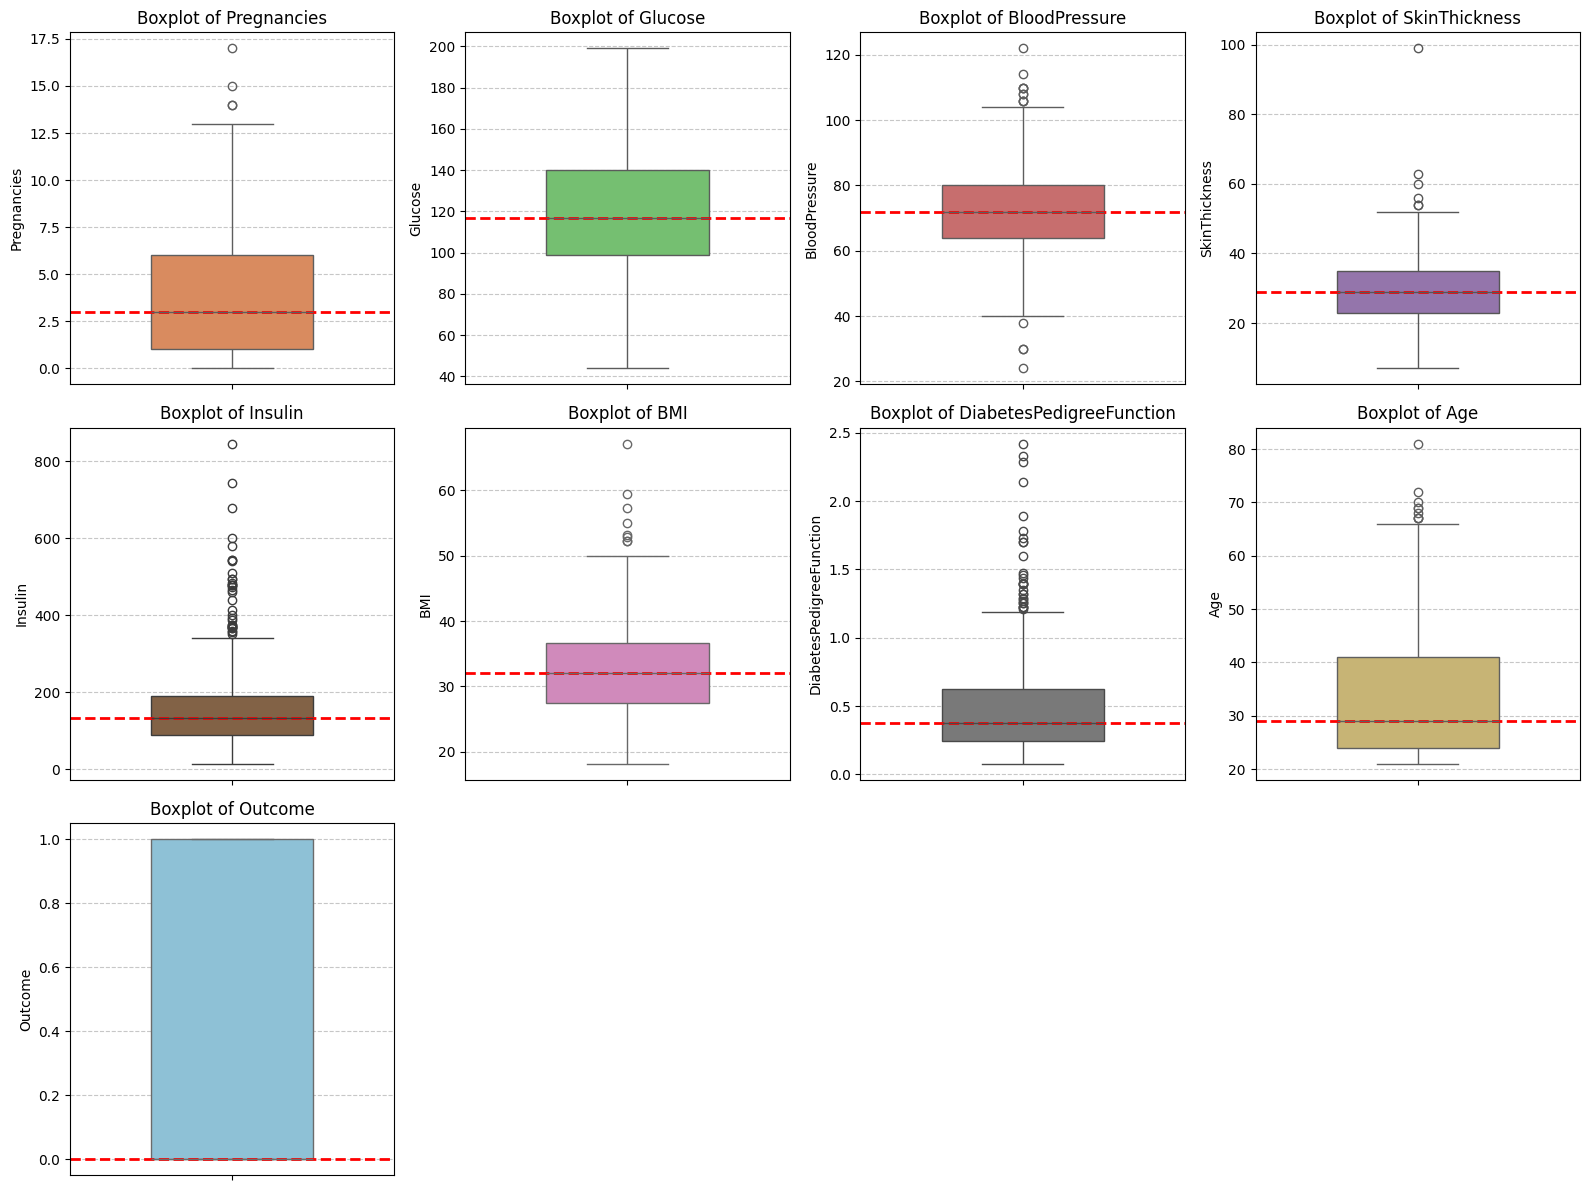

In [ ]:
#  look at the numeric variables if there is an outlier or not
import math
df=data
# Assume df is your DataFrame and you're plotting only numeric columns
numeric_cols = df.select_dtypes(include='number').columns
n = len(numeric_cols)

cols = 4
rows = math.ceil(n / cols)

palette = sns.color_palette('muted')

plt.figure(figsize=(4 * cols, 4 * rows))
for i, column in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[column], color=palette[i % len(palette)], width=0.5)
    plt.axhline(y=df[column].median(), color='red', linestyle='--', linewidth=2)
    plt.title(f'Boxplot of {column}', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


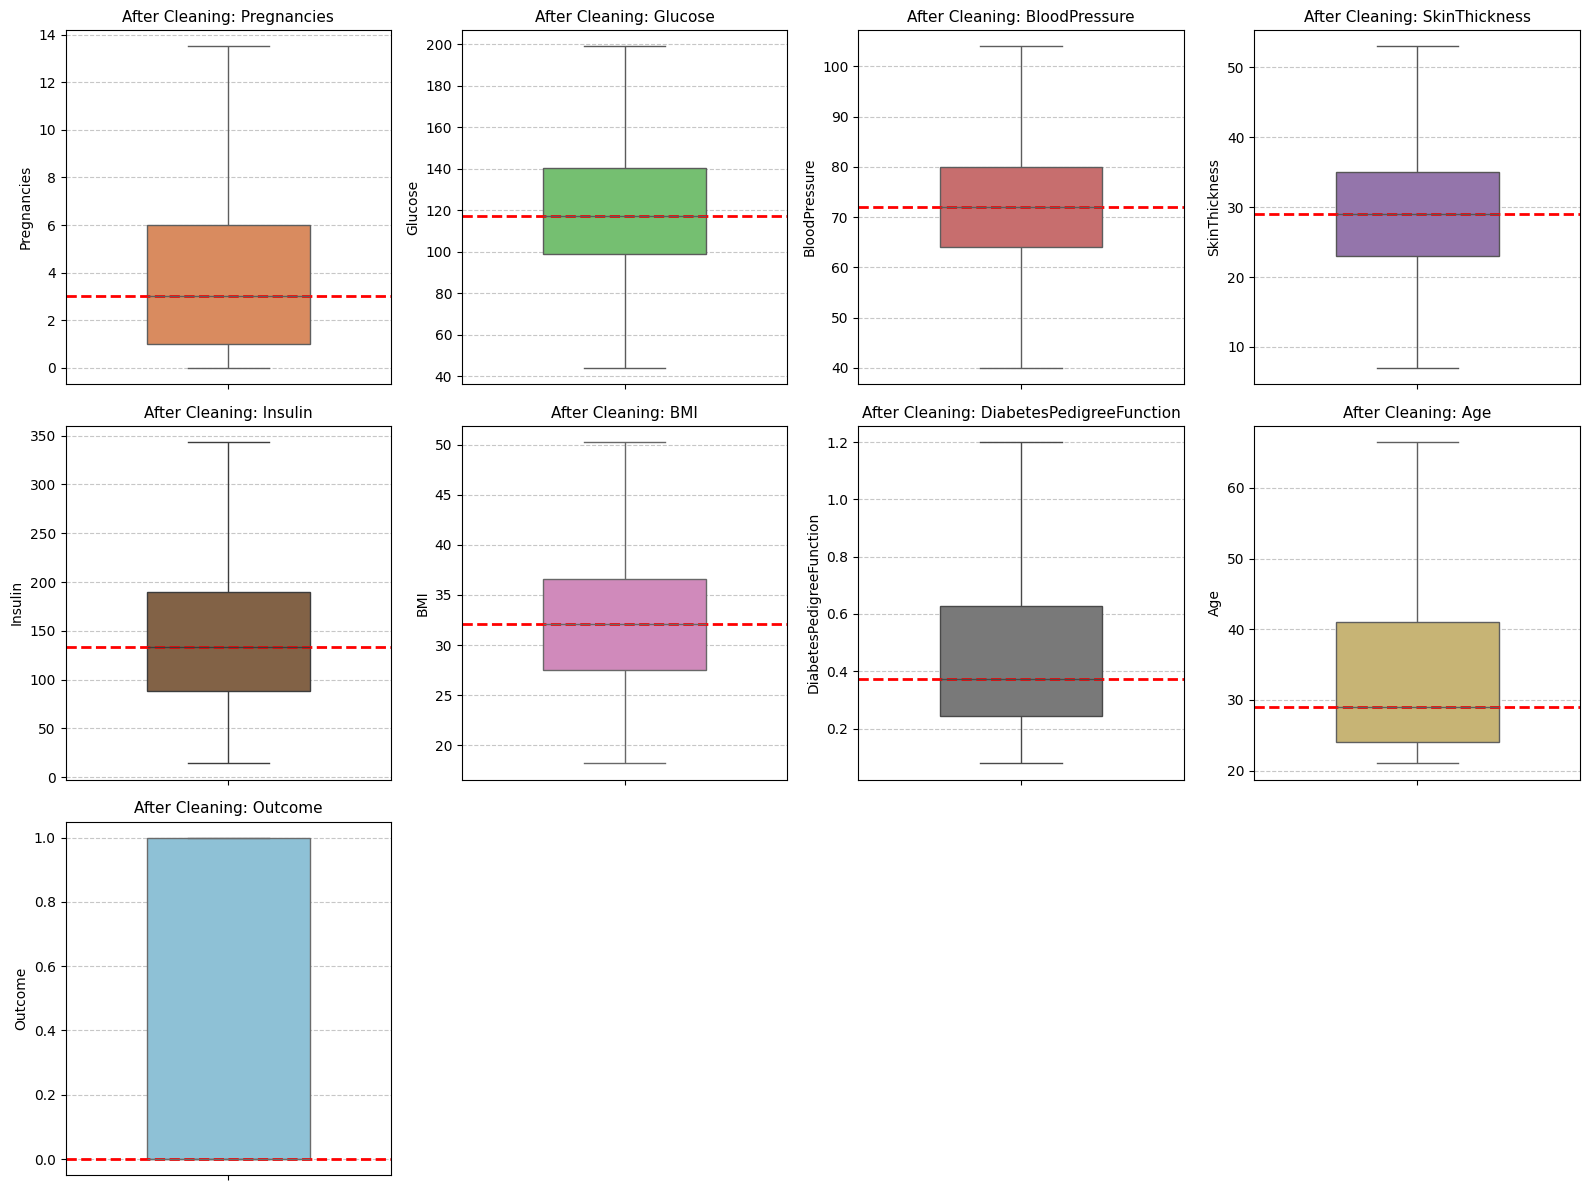

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# --- Select numeric columns ---
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# --- Function to replace outliers with threshold values using IQR ---
def replace_with_thresholds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# --- Apply outlier replacement to all numeric columns ---
data_imputed = df.copy()
for col in numeric_cols:
    data_imputed = replace_with_thresholds(data_imputed, col)

# --- Visualization function ---
def plot_boxplots(dataframe, title_prefix):
    n = len(numeric_cols)
    cols = 4
    rows = math.ceil(n / cols)
    palette = sns.color_palette('muted')

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(y=dataframe[column], color=palette[i % len(palette)], width=0.5)
        plt.axhline(y=dataframe[column].median(), color='red', linestyle='--', linewidth=2)
        plt.title(f'{title_prefix} {column}', fontsize=11)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Plot after cleaning ---
plot_boxplots(data_imputed, title_prefix="After Cleaning:")

# Optional: assign cleaned data back to df
df = data_imputed.copy()


> Bivariate Analysis
, Correlation heatmap to find strongly correlated features.

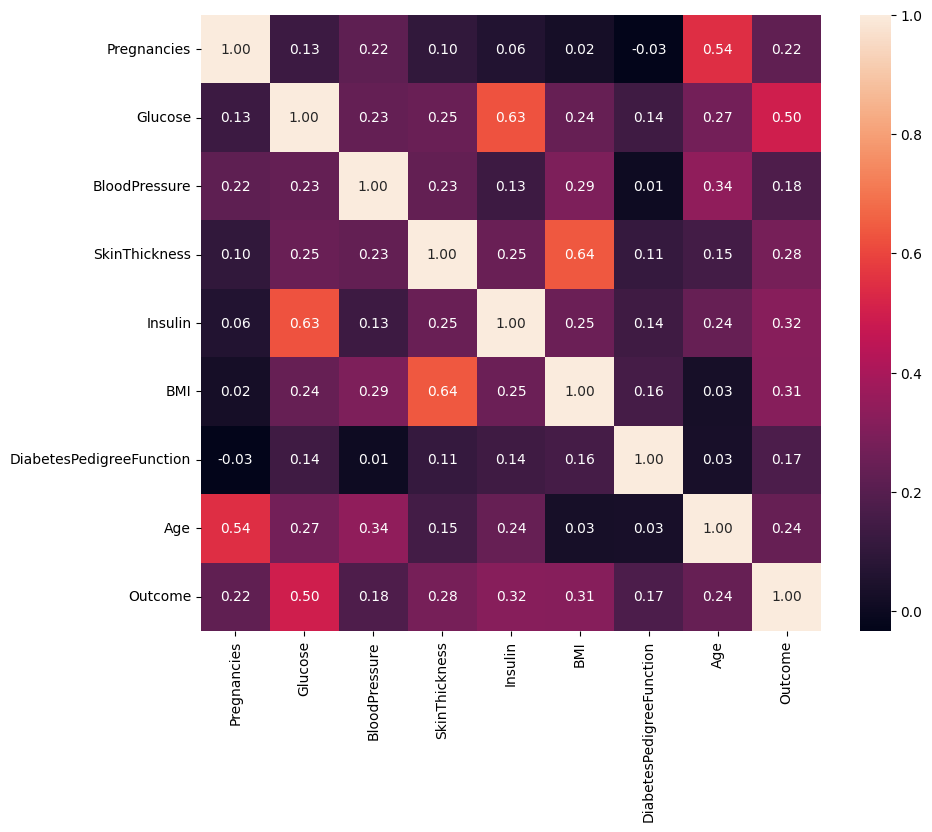

In [ ]:
# Correlation matrix
# Correlation matrix for numeric columns
numeric_columns = data.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

> analysis of distribution in column of dataset - varibles relation with Outcome:

* Visualize the distribution of data for each column in the dataset.
* Group the distributions by the Outcome variable ( diabetes positive or negative).
* Display bar labels for clarity and better interpretation of data.


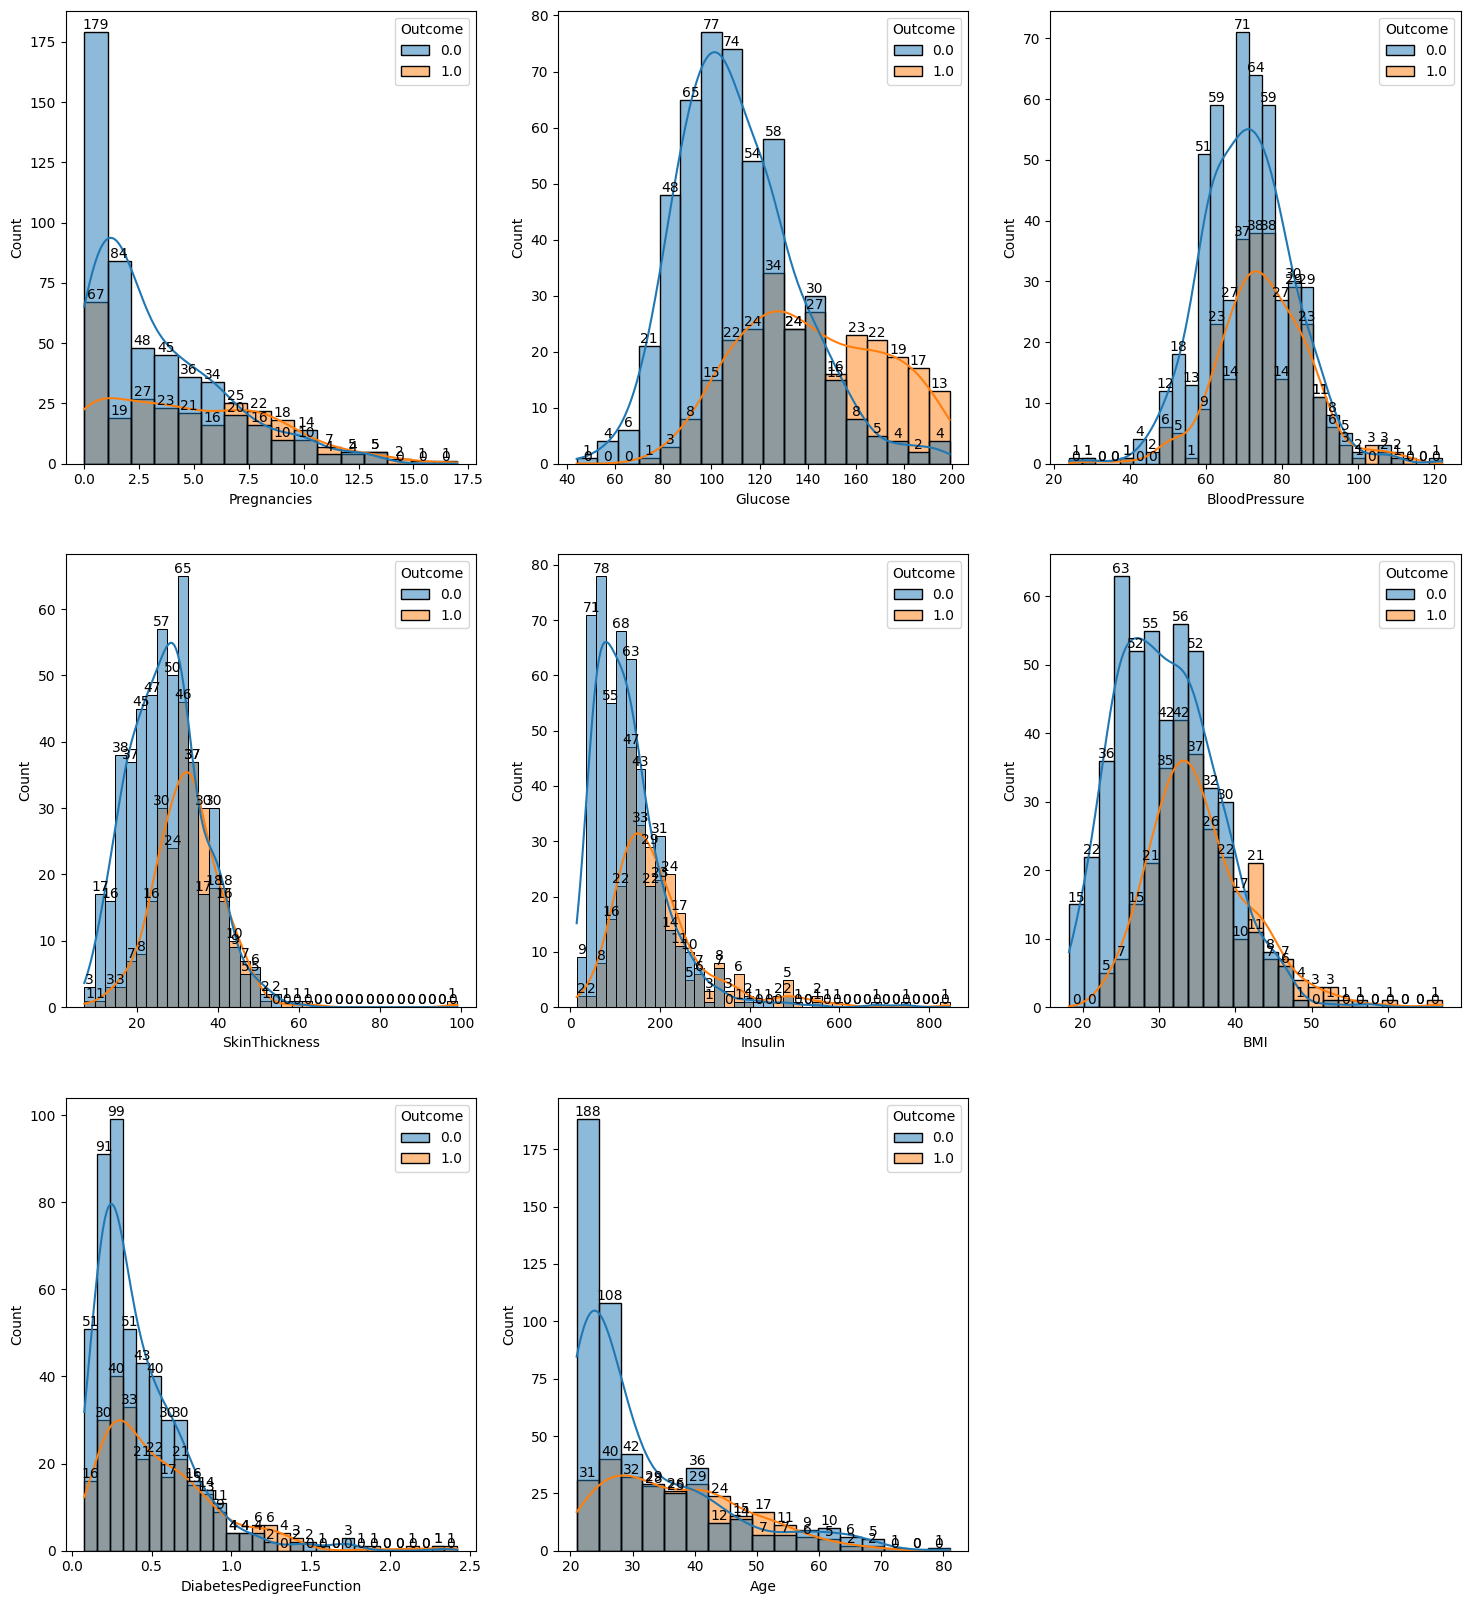

In [ ]:
pno = 1
plt.figure(figsize=(18,20))
for i in data.columns:
    if pno<9:
        plt.subplot(3,3,pno)
        ax = sns.histplot(data=data, x=i, hue=data.Outcome, kde=True);
        plt.xlabel(i)
        pno+=1
        for i in ax.containers:              # to set a label on the top of the bars.
            ax.bar_label(i,)

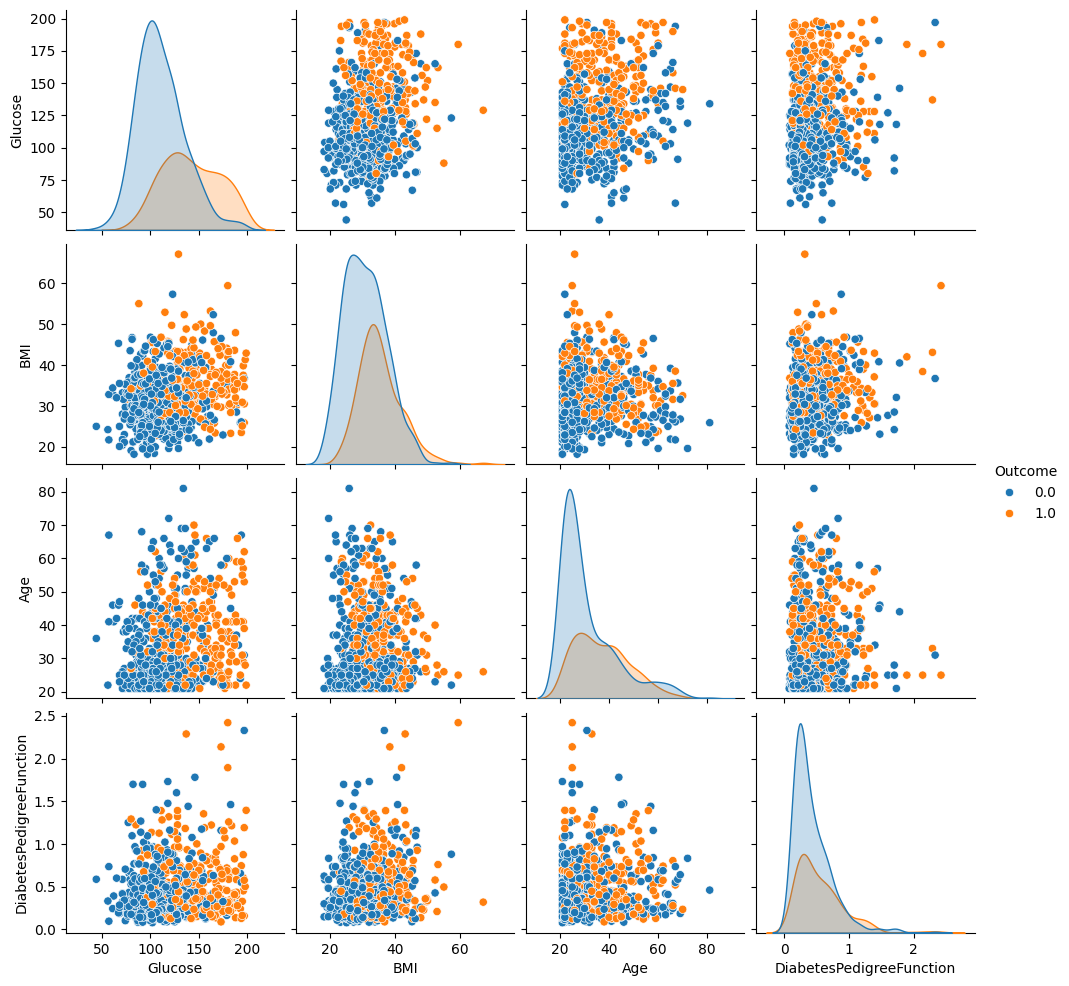

In [ ]:
important_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Outcome']

# Pairplot with selected features
sns.pairplot(data[important_features], hue='Outcome')
plt.show()

Insights
* **Glucose Levels:** Higher glucose levels are strongly associated with positive diabetes outcomes
* **BMI** Individuals with higher BMI values tend to have a higher likelihood of having diabetes.
* **Age** There seems to be a slight trend where older individuals are more likely to have diabetes.
* **Diabetes Pedigree Function** A higher value indicates a stronger family history of diabetes,
* **Blood Pressure, Skin Thickness, and Insulin:**
These features show less obvious trends in relation to the Outcome variable. They might have weaker correlations or interact with other variables in more complex ways.


In [ ]:
data_imputed=data
# Feature Engineering
def calculate_bmi_category(bmi):
    if pd.isna(bmi):
        return 'Unknown'
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'

def calculate_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    if age < 30:
        return 'Young'
    elif 30 <= age < 60:
        return 'Middle-aged'
    else:
        return 'Senior'

data_imputed = data_imputed.copy()
data_imputed['BMI_Category'] = data_imputed['BMI'].apply(calculate_bmi_category)
data_imputed['Age_Group'] = data_imputed['Age'].apply(calculate_age_group)
print("Columns after feature engineering:", data_imputed.columns.tolist())
print("BMI_Category values:\n", data_imputed['BMI_Category'].value_counts())
print("Sample data:\n", data_imputed[['BMI', 'BMI_Category', 'Age', 'Age_Group']].head())
data=data_imputed

Columns after feature engineering: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'BMI_Category', 'Age_Group']
BMI_Category values:
 BMI_Category
Obese          483
Overweight     180
Normal         101
Underweight      4
Name: count, dtype: int64
Sample data:
     BMI BMI_Category   Age    Age_Group
0  33.6        Obese  50.0  Middle-aged
1  26.6   Overweight  31.0  Middle-aged
2  23.3       Normal  32.0  Middle-aged
3  28.1   Overweight  21.0        Young
4  43.1        Obese  33.0  Middle-aged


In [ ]:
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Age_Group
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1.0,Obese,Middle-aged
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0,Overweight,Middle-aged
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1.0,Normal,Middle-aged
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight,Young
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0,Obese,Middle-aged


In [ ]:
# Check explained variance ratio
pca = PCA(n_components=4)
pca_feature=pca.fit(data[numerical_cols])
pca_feature = pd.DataFrame(data_pca, columns=['PC1', 'PC2','PC3','PC4' ])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Retained:", sum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.9134815  0.05027177 0.01620902 0.0099823 ]
Total Variance Retained: 0.9899445906011487


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

numerical_cols = data.select_dtypes(include='number').columns.drop('Outcome')
# Select top 5 features
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(data[numerical_cols], data['Outcome'])


# Check selected feature names
selected_features = [numerical_cols[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

Selected Features: ['Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


# Modeling

In [ ]:
data['BMI_Category'] = data['BMI_Category'].astype(str)
data['Age_Group'] = data['Age_Group'].astype(str)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Ensure categorical columns are strings
data['BMI_Category'] = data['BMI_Category'].astype(str)
data['Age_Group'] = data['Age_Group'].astype(str)

# Define categorical columns
categorical_cols = ['BMI_Category', 'Age_Group']

# Initialize and apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output=False to get dense output
encoded_features = pd.DataFrame(
    encoder.fit_transform(data[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),  # Get meaningful column names
    index=data.index  # Retain the original index
)

# Replace the original categorical columns with encoded features
data = data.drop(columns=categorical_cols).join(encoded_features)

# Check the DataFrame
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.0  33.6   
1          1.0     85.0           66.0           29.0     58.6  26.6   
2          8.0    183.0           64.0           25.8    164.6  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction   Age  Outcome  BMI_Category_Obese  \
0                     0.627  50.0      1.0                 1.0   
1                     0.351  31.0      0.0                 0.0   
2                     0.672  32.0      1.0                 0.0   
3                     0.167  21.0      0.0                 0.0   
4                     2.288  33.0      1.0                 1.0   

   BMI_Category_Overweight  BMI_Category_Underweight  Age_Group_Senior  \
0                      0.0                       0.0               0.0   
1                     

In [ ]:

# Define Features (X) and Target (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

# Define Models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC(probability=True)),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier())
]

# Hyperparameter Tuning
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [5, 7, 9]},
    'SVC': {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

best_models = {}
for name, model in models:
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")

# Evaluate Models
for name, model in best_models.items():
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, proba):.2f}" if proba is not None else "No ROC AUC Available")
    print(f"Classification Report:\n{classification_report(y_test, preds)}")

# Voting Classifier (Ensemble)
ensemble = VotingClassifier(estimators=list(best_models.items()), voting='soft')
ensemble.fit(X_resampled, y_resampled)
ensemble_preds = ensemble.predict(X_test)

print("--- Ensemble Model ---")
print(f"Accuracy: {accuracy_score(y_test, ensemble_preds):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1]):.2f}")
print(f"Classification Report:\n{classification_report(y_test, ensemble_preds)}")

Tuning hyperparameters for Logistic Regression...
Best Parameters for Logistic Regression: {'C': 1}
Tuning hyperparameters for KNN...
Best Parameters for KNN: {'n_neighbors': 5}
Tuning hyperparameters for SVC...
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Tuning hyperparameters for Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Tuning hyperparameters for AdaBoost...
Best Parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
Tuning hyperparameters for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:49:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Tuning hyperparameters for LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:49:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# model Evaluation

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-488-d2c015828067>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
<ipython-input-488-d2c015828067>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

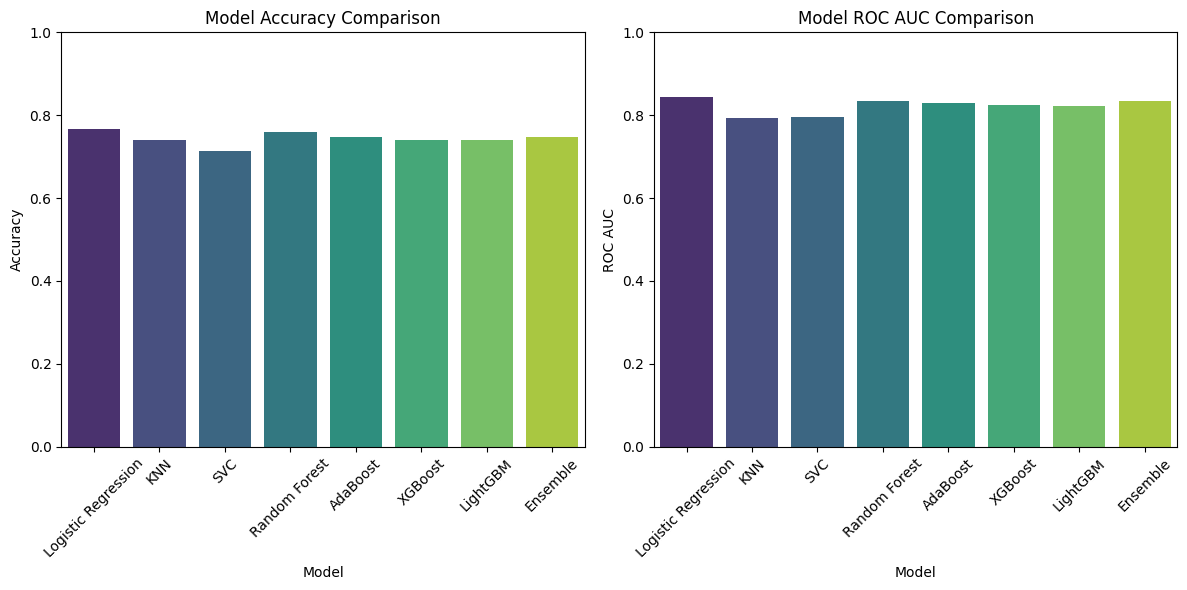

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 600x600 with 0 Axes>

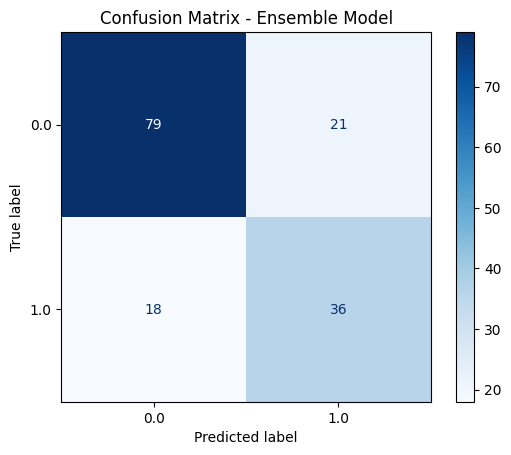

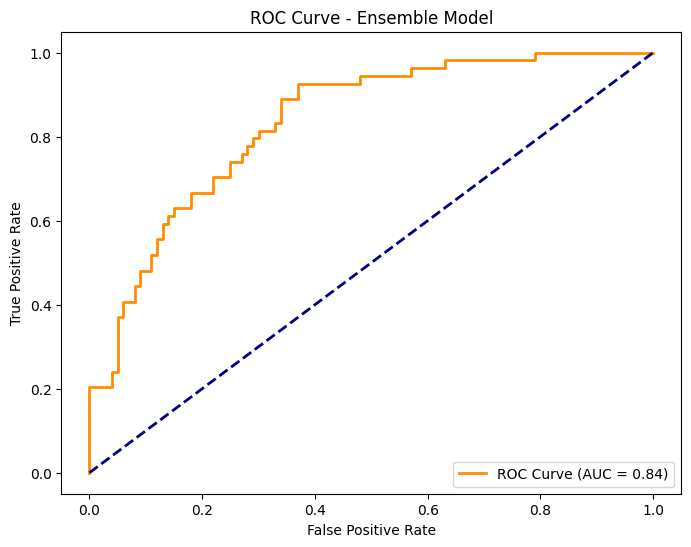

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Store model results for visualization
model_results = []
for name, model in best_models.items():
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, proba) if proba is not None else None
    model_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    })

# Add Ensemble Model to Results
ensemble_proba = ensemble.predict_proba(X_test)[:, 1]
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_proba)
model_results.append({
    'Model': 'Ensemble',
    'Accuracy': ensemble_accuracy,
    'ROC AUC': ensemble_roc_auc
})

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(model_results)

# Bar Plot for Accuracy and ROC AUC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Model', y='ROC AUC', palette='viridis')
plt.title('Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Confusion Matrix for Ensemble Model
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(ensemble, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

# ROC Curve for Ensemble Model
fpr, tpr, thresholds = roc_curve(y_test, ensemble_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc='lower right')
plt.show()